<a href="https://colab.research.google.com/github/swathi156/swathi156/blob/main/heart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import pickle as pickle

import torch
import torch.nn as nn
from matplotlib import pyplot as plt

In [2]:
pids = pd.read_pickle('/content/pids.pkl')
vids = pd.read_pickle('/content/vids.pkl')
hfs = pd.read_pickle('/content/hfs.pkl')
seqs = pd.read_pickle('/content/seqs.pkl')
types = pd.read_pickle('/content/types.pkl')
rtypes = pd.read_pickle('/content/rtypes.pkl')

In [3]:
total_patients = len(pids)
total_visits = len(pd.DataFrame(vids).stack())
total_records = len(pd.DataFrame(seqs).stack().explode())
total_hfs = sum(hfs)
hfs_ratio = sum(hfs) / len(hfs)

highest_visit_count = pd.DataFrame(vids).stack()
highest_visit_count = highest_visit_count .groupby(level=0).count().max()

print(f"Total patients: {total_patients}")
print(f"Total amount of visits: {total_visits}")
print(f"Highest visit amount for a single patient: {highest_visit_count}")
print(f"Total amount of clinical records: {total_records}")
print(f"Total amount of patients with heart failure: {total_hfs}")
print(f"Rato of heart failure patients: {hfs_ratio}")

Total patients: 1000
Total amount of visits: 2375
Highest visit amount for a single patient: 30
Total amount of clinical records: 27115
Total amount of patients with heart failure: 548
Rato of heart failure patients: 0.548


In [4]:
def get_patient_data(index):
    patient_stats = pd.DataFrame({
        "ID": pids[index],
        "Visits": len(vids[index]),
        "Heart failure": bool(hfs[index])
    }, index=[index])

    return patient_stats

In [5]:
print("\nExample patient:")
get_patient_data(3)



Example patient:


,ID,Visits,Heart failure
3,47537,2,False


In [6]:
def get_patient_visit(index, visit):

    patient_visit = pd.DataFrame({
        'event_id': seqs[index][visit]
    })

    patient_visit['event'] = patient_visit.event_id.map(rtypes)

    return patient_visit

In [7]:
print("Details of patient visit:")
get_patient_visit(3, 0)

Details of patient visit:


,event_id,event
0,12,DIAG_041
1,103,DIAG_276
2,262,DIAG_518
3,285,DIAG_560
4,290,DIAG_567
5,292,DIAG_569
6,359,DIAG_707
7,416,DIAG_785
8,39,DIAG_155
9,225,DIAG_456


In [8]:
def collate_fn(data):

    sequences, labels = zip(*data)

    num_patients = len(sequences)
    max_num_visits = 0
    max_num_codes = 0

    for patient in sequences:
        max_num_visits = max(max_num_visits, len(patient))
        for visit in patient:
            max_num_codes = max(max_num_codes, len(visit))

    shape = (num_patients, max_num_visits, max_num_codes)

    y = torch.tensor(labels, dtype=torch.float)
    x = torch.zeros(shape, dtype=torch.long)
    rev_x = torch.zeros(shape, dtype=torch.long)
    masks = torch.zeros(shape, dtype=torch.bool)
    rev_masks = torch.zeros(shape, dtype=torch.bool)

    for i, patient in enumerate(sequences):
        for j, visit in enumerate(patient):

            x[i,j,:len(visit)] = torch.tensor(visit, dtype=torch.long)
            masks[i,j, :len(visit)] = 1

            rev_x[i, len(patient) - j - 1, :len(visit)] = torch.tensor(visit, dtype=torch.long)
            rev_masks[i, len(patient) - j - 1, :len(visit)] = 1


    return x, masks, rev_x, rev_masks, y

In [9]:
def load_data(train_dataset, val_dataset, collate_fn):

    batch_size = 32

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn
    )

    return train_loader, val_loader

In [10]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, seqs, hfs):
        self.x = seqs
        self.y = hfs


    def __len__(self):
        return len(self.x)


    def __getitem__(self, index):
        return (self.x[index], self.y[index])

In [11]:
dataset = CustomDataset(seqs, hfs)

split = int(len(dataset)*0.8)
lengths = [split, len(dataset) - split]

train_dataset, val_dataset = torch.utils.data.dataset.random_split(dataset, lengths)

train_loader, val_loader = load_data(train_dataset, val_dataset, collate_fn)

In [12]:
class AlphaAttention(torch.nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.a_att = nn.Linear(hidden_dim, 1)


    def forward(self, g):
        alpha = self.a_att(g)
        alpha = torch.softmax(alpha, 1)
        return alpha


class BetaAttention(torch.nn.Module):

    def __init__(self, hidden_dim):
        super().__init__()
        self.b_att = nn.Linear(hidden_dim, hidden_dim)


    def forward(self, h):
        beta = self.b_att(h)
        beta = torch.tanh(beta)
        return beta


def attention_sum(alpha, beta, rev_v, rev_masks):
    c = (torch.sum(rev_masks, -1) > 0).type(torch.float)
    c = c.unsqueeze(-1)
    c = torch.sum(alpha * beta * rev_v * c, dim=1)
    return c


def sum_embeddings_with_mask(x, masks):
    x = x * masks.unsqueeze(-1)
    x = torch.sum(x, dim = -2)
    return x

In [13]:
class RETAIN(nn.Module):

    def __init__(self, num_codes, embedding_dim=128):
        super().__init__()

        self.embedding = nn.Embedding(num_codes, embedding_dim)

        self.rnn_a = nn.GRU(embedding_dim, embedding_dim, batch_first=True)
        self.rnn_b = nn.GRU(embedding_dim, embedding_dim, batch_first=True)

        self.att_a = AlphaAttention(embedding_dim)
        self.att_b = BetaAttention(embedding_dim)

        self.fc = nn.Linear(embedding_dim, 1)

        self.sigmoid = nn.Sigmoid()


    def forward(self, x, masks, rev_x, rev_masks):

        rev_x = self.embedding(rev_x)
        rev_x = sum_embeddings_with_mask(rev_x, rev_masks)

        g, _ = self.rnn_a(rev_x)
        h, _ = self.rnn_b(rev_x)

        alpha = self.att_a(g)
        beta = self.att_b(h)

        c = attention_sum(alpha, beta, rev_x, rev_masks)

        logits = self.fc(c)
        probs = self.sigmoid(logits)
        return probs.squeeze()

In [14]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score


def eval(model, val_loader):


    y_pred = torch.LongTensor()
    y_score = torch.Tensor()
    y_true = torch.LongTensor()

    model.eval()

    for x, masks, rev_x, rev_masks, y in val_loader:
        y_logit = model(x, masks, rev_x, rev_masks)

        y_hat = y_logit >= 0.5

        y_score = torch.cat((y_score,  y_logit.detach().to('cpu')), dim=0)
        y_pred = torch.cat((y_pred,  y_hat.detach().to('cpu')), dim=0)
        y_true = torch.cat((y_true, y.detach().to('cpu')), dim=0)

    p, r, f, _ = precision_recall_fscore_support(y_true, y_pred, average='binary')
    roc_auc = roc_auc_score(y_true, y_score)

    return p, r, f, roc_auc

In [15]:
retain = RETAIN(num_codes = len(types))
print(retain)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(retain.parameters(), lr=1e-3)
n_epochs = 20

history = []



RETAIN(
  (embedding): Embedding(619, 128)
  (rnn_a): GRU(128, 128, batch_first=True)
  (rnn_b): GRU(128, 128, batch_first=True)
  (att_a): AlphaAttention(
    (a_att): Linear(in_features=128, out_features=1, bias=True)
  )
  (att_b): BetaAttention(
    (b_att): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


In [16]:
retain = RETAIN(num_codes = len(types))
print(retain)

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(retain.parameters(), lr=1e-3)
n_epochs = 20

history = []



def train(model, train_loader, val_loader, n_epochs):

    model.train()

    for epoch in range(n_epochs):

        train_loss = 0

        for x, masks, rev_x, rev_masks, y in train_loader:
            optimizer.zero_grad()
            y_hat = model(x, masks, rev_x, rev_masks)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()



        train_loss = train_loss / len(train_loader)
        p, r, f, roc_auc = eval(model, val_loader)
        history.append([p,r,f,roc_auc])
        print('Epoch: {} \t Training Loss:  {:.6f}, Validation precision: {:.2f}, recall:{:.2f}, f-score: {:.2f}, roc_auc: {:.2f}'.format(epoch, train_loss, p, r, f, roc_auc))

    return round(roc_auc, 2)


train(retain, train_loader, val_loader, n_epochs)

RETAIN(
  (embedding): Embedding(619, 128)
  (rnn_a): GRU(128, 128, batch_first=True)
  (rnn_b): GRU(128, 128, batch_first=True)
  (att_a): AlphaAttention(
    (a_att): Linear(in_features=128, out_features=1, bias=True)
  )
  (att_b): BetaAttention(
    (b_att): Linear(in_features=128, out_features=128, bias=True)
  )
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch: 0 	 Training Loss:  0.635306, Validation precision: 0.74, recall:0.82, f-score: 0.78, roc_auc: 0.76
Epoch: 1 	 Training Loss:  0.429755, Validation precision: 0.78, recall:0.75, f-score: 0.77, roc_auc: 0.79
Epoch: 2 	 Training Loss:  0.268698, Validation precision: 0.77, recall:0.82, f-score: 0.80, roc_auc: 0.80
Epoch: 3 	 Training Loss:  0.139267, Validation precision: 0.78, recall:0.75, f-score: 0.77, roc_auc: 0.79
Epoch: 4 	 Training Loss:  0.064885, Validation precision: 0.75, recall:0.88, f-score: 0.81, roc_auc: 0.79
Epoch: 5 	 Training Loss:  0.032903, Validation precision: 0.

0.8

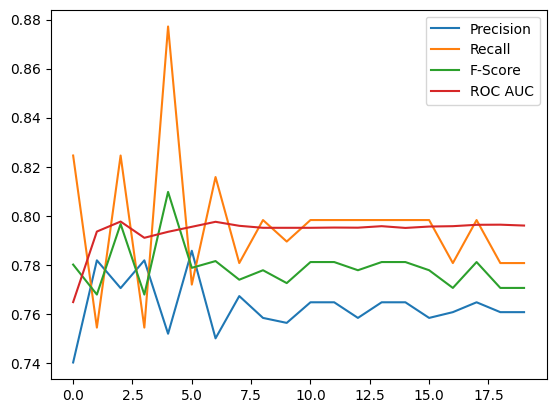

In [17]:
plt.plot(history)
plt.legend(['Precision', 'Recall', 'F-Score', 'ROC AUC'])
plt.show()

In [18]:
print("Precision = {} Recall = {} f-score = {}  roc_auc = {}".format(*eval(retain, val_loader)))


for x, masks, rev_x, rev_masks, y in val_loader:
    y_hat = retain(x, masks, rev_x, rev_masks)

    y_hat_single = y_hat[0]
    pred = y_hat_single > 0.5

    print(f"prediction = {pred}\t y = {bool(y[0])}\t which is {'correct' if pred == y[0] else 'incorrect'}\t y_hat = {y_hat_single}")

Precision = 0.7606837606837606 Recall = 0.7807017543859649 f-score = 0.7705627705627706  roc_auc = 0.7958996328029376
prediction = True	 y = True	 which is correct	 y_hat = 0.9999123811721802
prediction = True	 y = True	 which is correct	 y_hat = 0.9999991655349731
prediction = False	 y = False	 which is correct	 y_hat = 8.00794532551663e-06
prediction = True	 y = False	 which is incorrect	 y_hat = 0.9999979734420776
prediction = True	 y = True	 which is correct	 y_hat = 0.898949384689331
prediction = True	 y = True	 which is correct	 y_hat = 0.9999748468399048
prediction = False	 y = False	 which is correct	 y_hat = 0.004298618528991938


In [19]:
torch.save(retain.state_dict(), "model.pt")